# Abstract

This uses the an [energy-production dataset](https://fred.stlouisfed.org/series/IPG2211A2N) to experiment with a variety of time-series models.

Basics:

 1. ARIMA for forecasting
 2. SARIMA for seasonal forecasts
     3. For long-distance seasons (e.g. years on a daily granualarity) consider using fourier terms
 3. (S)ARIMAX for forecasting with covariates.
 
Tools
 1. BSTS: Bayesian structure time-series
 2. Auto Arima in Python
 3. PyMC

Sources:

 1. [Using Auto-Arima in Python for forecasting](https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c)
 1. [More on Python ARIMA forecasting](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3)
 2. [Extremely nice ARIMA tutorial](https://www.datascience.com/blog/introduction-to-forecasting-with-arima-in-r-learn-data-science-tutorials), includes ACF, PACF
 2. [Good course on time-series, from ARIMA to Spectral Analysis](https://onlinecourses.science.psu.edu/stat510/node/41/)
 3. [Good course on ARIMA](https://people.duke.edu/~rnau/seasarim.htm), with practical tips like [when to use log](https://people.duke.edu/~rnau/seasarim.htm#log)
 3. [Maths of ARIMA](http://www.maths.qmul.ac.uk/~bb/TimeSeries/TS_Chapter7.pdf), note that differencing inherently leads to auto-correlation, which is why differencing may lead to negative PACF scores that need AR lags.
 3. [Wikipedia on the Lag Operator](https://en.wikipedia.org/wiki/Lag_operator)
 4. [An entire book on forecasting](https://otexts.org/fpp2/seasonal-arima.html)
 5. [Augmenting ARIMA with Fourier terms using R](https://robjhyndman.com/hyndsight/forecasting-weekly-data/), it's built in. It seems the model is use linear regression with fourier terms to fit your data, then use ARIMA to model the residuals. Also explains [why to use Fourier terms instead of SARIMAX for long periods](https://robjhyndman.com/hyndsight/longseasonality/)
 6. [Most on using Fourier terms for seasonality with AIC to determine term count](https://content.pivotal.io/blog/forecasting-time-series-data-with-multiple-seasonal-periods)
 7. [ARIMAX](https://robjhyndman.com/hyndsight/arimax/)
 8. [Sorry ARIMA, but I'm going Bayesian](https://www.reddit.com/r/statistics/comments/4fw1bn/sorry_arima_but_im_going_bayesian/)

Some more work on RNNs

1. [Recurrent Neural network for time-series modelling](https://www.nature.com/articles/s41598-018-24271-9)

PyMC Examples
1. [Stochastic Volatility Model](https://docs.pymc.io/notebooks/stochastic_volatility.html)
2. [Random-Walk Bayesian Deep networks](http://twiecki.github.io/blog/2017/03/14/random-walk-deep-net/)
3. [Escaping funnels in MCMC](https://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/) referencing a paper by [Betancourt and Girolami](https://arxiv.org/pdf/1312.0906.pdf)
4. [Copulas](https://twiecki.github.io/blog/2018/05/03/copulas/)

Books
1. [Bayesian Filtering and Smoothing](https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf)
2. 

Kaggles
1. [Ensemble of ARIMA and Deep Nets for Wikipedia traffic](https://www.kaggle.com/screech/ensemble-of-arima-and-lstm-model-for-wiki-pages)
2. [Using Facebook's Prophet tool](https://www.kaggle.com/zoupet/predictive-analysis-with-different-approaches)
3. [ARIMA on stock prices](https://www.kaggle.com/kp4920/s-p-500-stock-data-time-series-analysis)
 
 
Some sample papers:

 1. [Gaussian Approx of stochastic differential equations](http://publications.aston.ac.uk/11096/1/archambeau07a.pdf)
 2. [Intro to Gaussian processes (covers similarity to Weiner, Ulbeck)](https://galton.uchicago.edu/~lalley/Courses/386/GaussianProcesses.pdf)

# Prelude

## Imports

In [58]:
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as sp
import seaborn as sns
sns.set()
import plotly
plotly.tools.set_credentials_file(
    username='bryanfeeney', 
    api_key='jOvZKtCWszCcItcwlYEP')


plt.style.use('fivethirtyeight')

# ARIMA Experiments

## Industrial Dataset using Auto-Arima (via Pyramid)

First note that ARIMA does _not_ incorporate seasonality. If that's the case then you need to need to have an additional seasonal component (SARIMA)

In [3]:
data = pd.read_csv(
    "../datasets/industrial-production/IPG2211A2N.csv", index_col=0)

In [4]:
data.head()

,IPG2211A2N
DATE,
1939-01-01,3.3842
1939-02-01,3.4100
1939-03-01,3.4875
1939-04-01,3.5133
1939-05-01,3.5133


In [5]:
data.index = pd.to_datetime(data.index)

In [6]:
data.head()

,IPG2211A2N
DATE,
1939-01-01,3.3842
1939-02-01,3.4100
1939-03-01,3.4875
1939-04-01,3.5133
1939-05-01,3.5133


In [7]:
data.columns = ['EnergyProd']

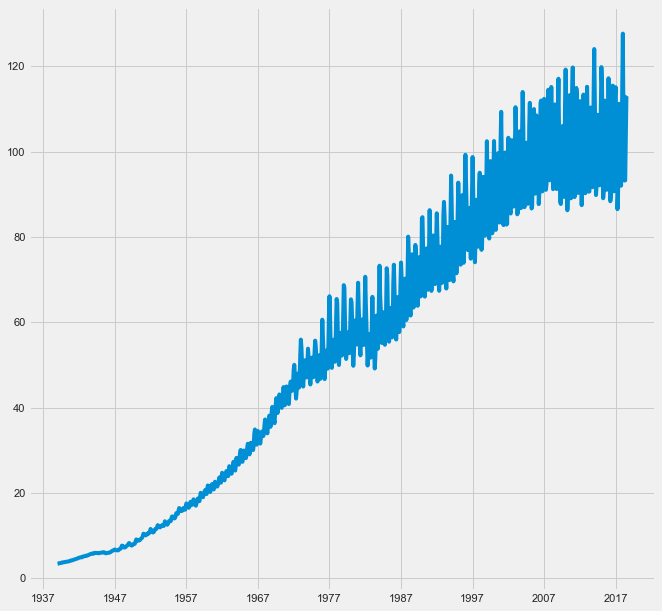

In [59]:
plt.figure(figsize=(10,10))
plt.plot(data);

Lets just consider three years, to investigate seasonality

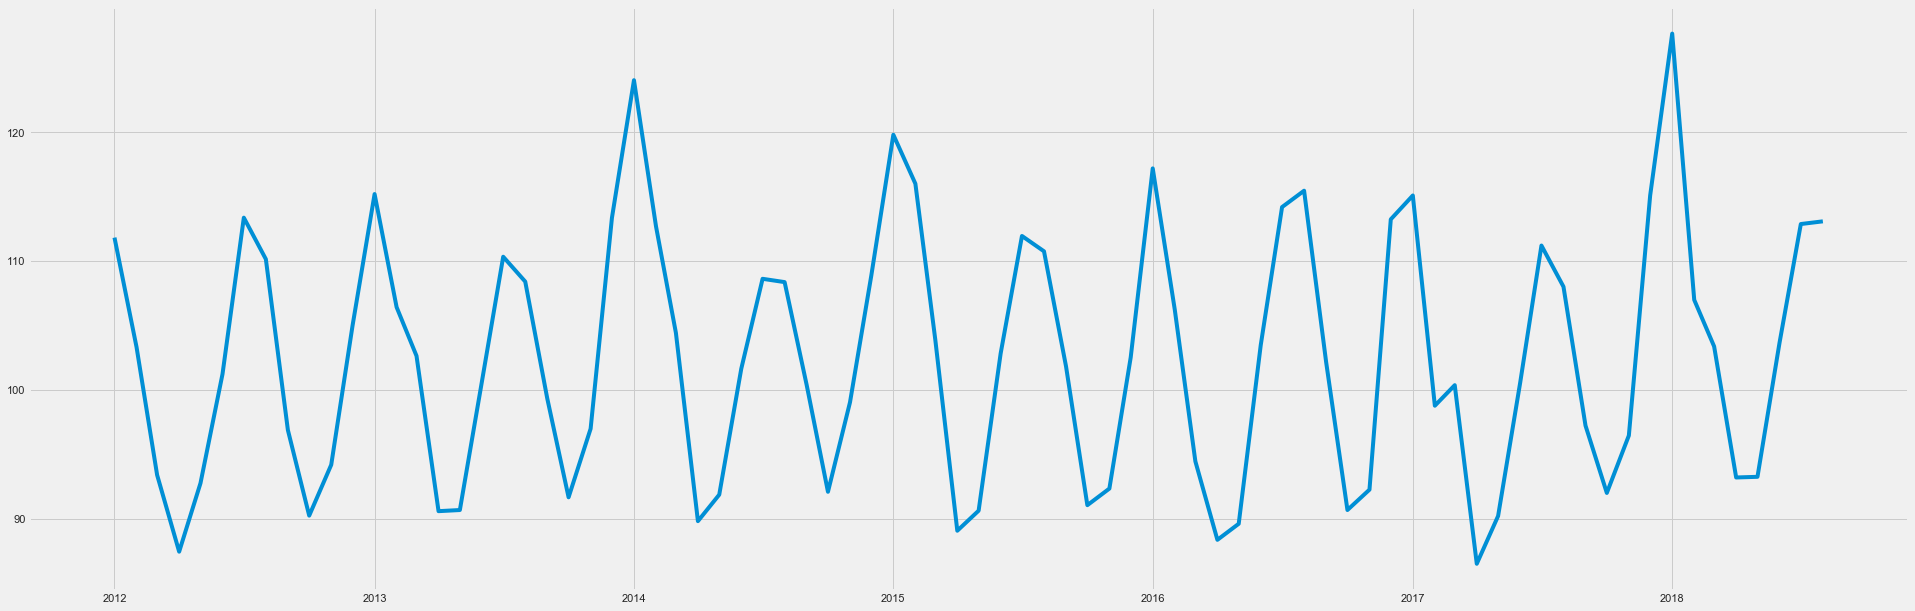

In [60]:
plt.figure(figsize=(30,10))
plt.plot(data[data.index >= '2012-01-01']);

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib as mpl

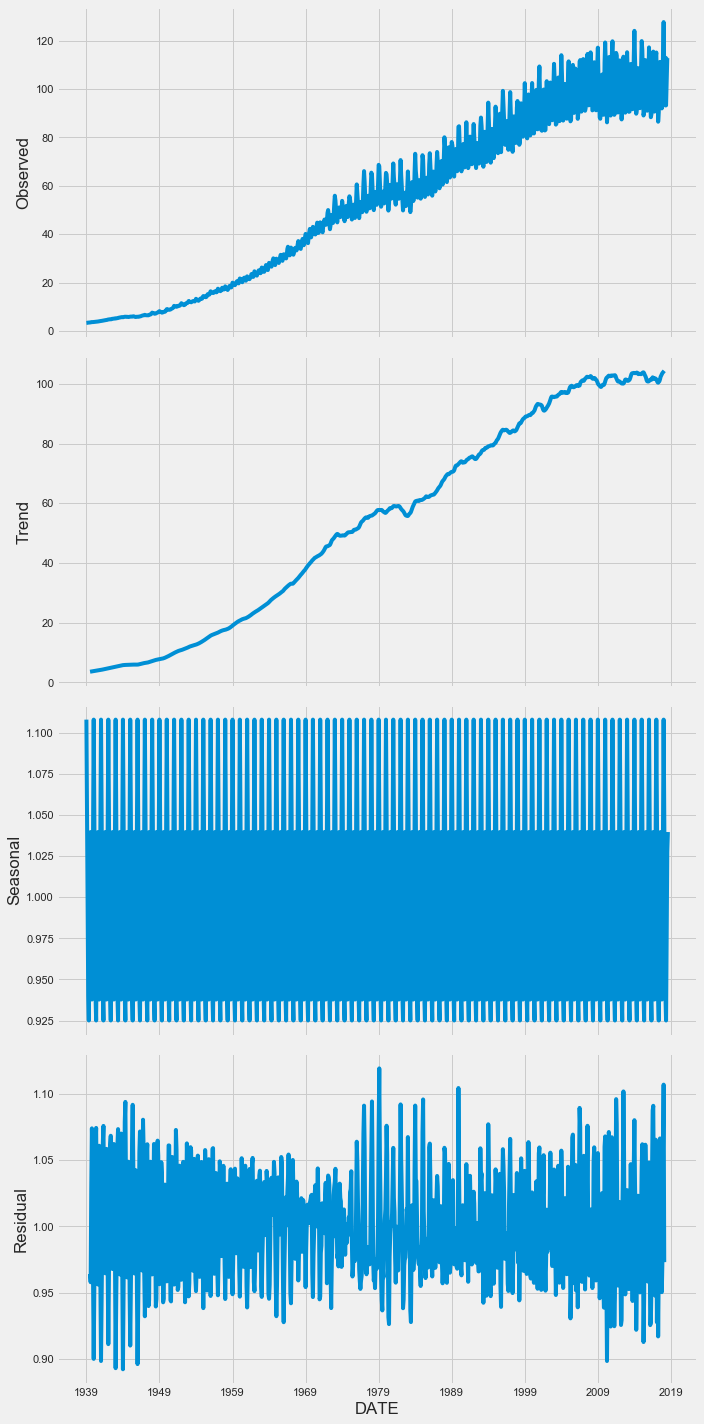

In [61]:
decomp = seasonal_decompose(data.EnergyProd, model='multiplicative')

with mpl.rc_context():
    mpl.rc("figure", figsize=(10, 20))
    fig = decomp.plot()


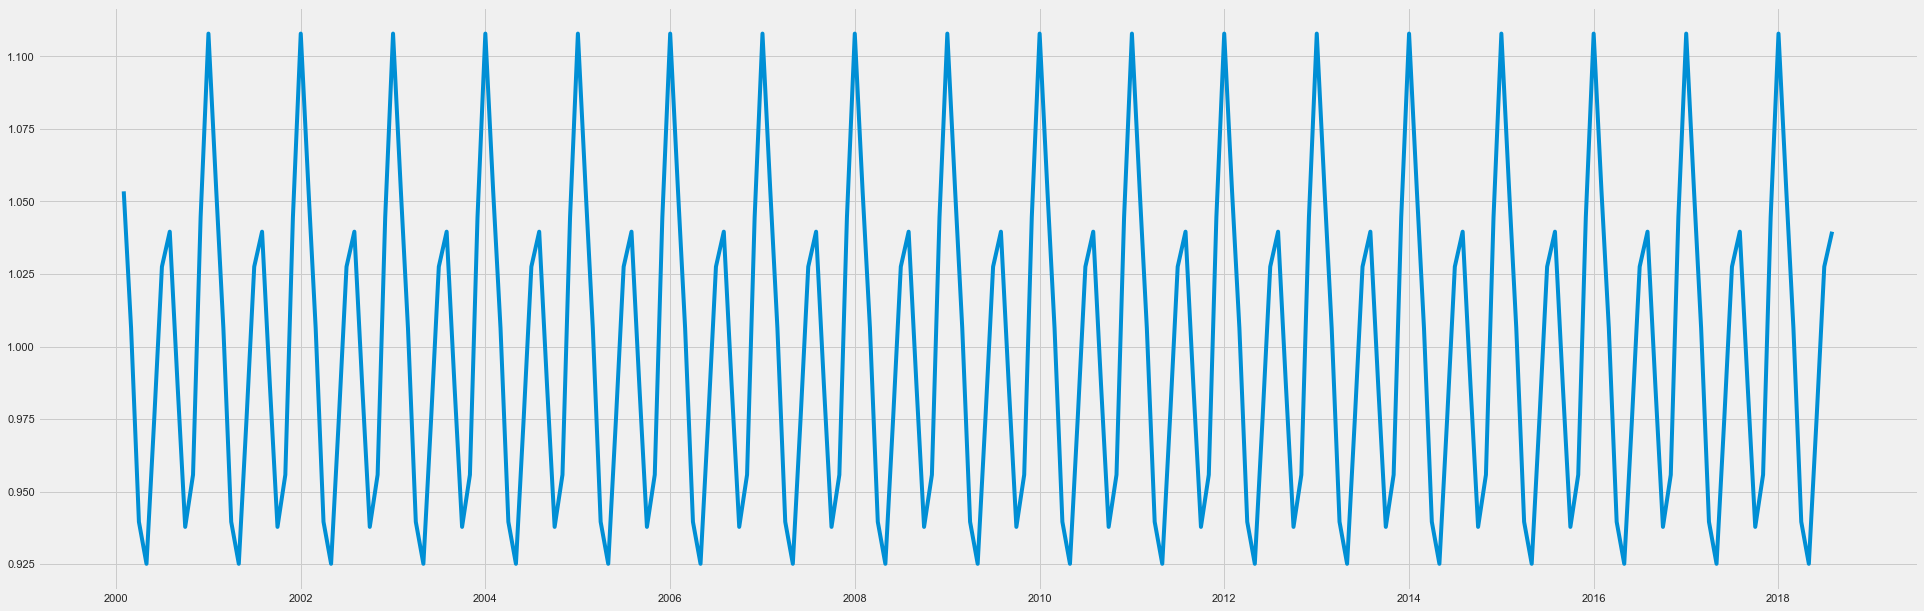

In [62]:
plt.figure(figsize=(30,10))
plt.plot(decomp.seasonal[decomp.seasonal.index > '2000-01-01']);

Are residuals multiplicative?

In [ ]:
Are residuals multiplicative

Fuse two ARIMA models together:
 
 1. The trend
 2. The seasonal component

In [39]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(data, 
                            start_p=1, d=1, start_q=1,
                            max_p=3,        max_q=3, 
                            m=12,
                            start_P=0, D=1, seasonal=True,
                            trace=True,
                            error_action='ignore', suppress_warnings=True, stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3737.559, BIC=3761.804, Fit time=3.686 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4239.900, BIC=4249.598, Fit time=0.078 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4059.190, BIC=4078.586, Fit time=1.062 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3860.433, BIC=3879.830, Fit time=1.420 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3737.211, BIC=3766.306, Fit time=4.557 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=3899.471, BIC=3923.717, Fit time=2.840 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3731.255, BIC=3765.199, Fit time=16.793 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3854.530, BIC=3883.625, Fit time=6.775 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3727.802, BIC=3766.594, Fit time=17.140 seconds
Fit ARIMA: order=(2, 1, 0)

In [44]:
train = data.loc['1985-01-01':'2016-12-01']
test = data.loc['2017-01-01':]

In [41]:
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(3, 1, 3),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 1, 2, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [45]:
future_forecast = stepwise_model.predict(n_periods=20)

In [49]:
future_forecast_df = pd.DataFrame(future_forecast, index=test.index, columns=['Prediction'])
eval_df = pd.concat([future_forecast_df, test])

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




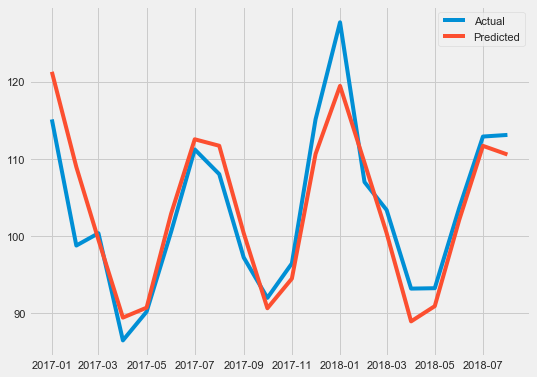

In [63]:
plt.figure(figsize=(8,6))
plt.plot(eval_df.EnergyProd, label="Actual")
plt.plot(eval_df.Prediction, label="Predicted")
plt.legend()

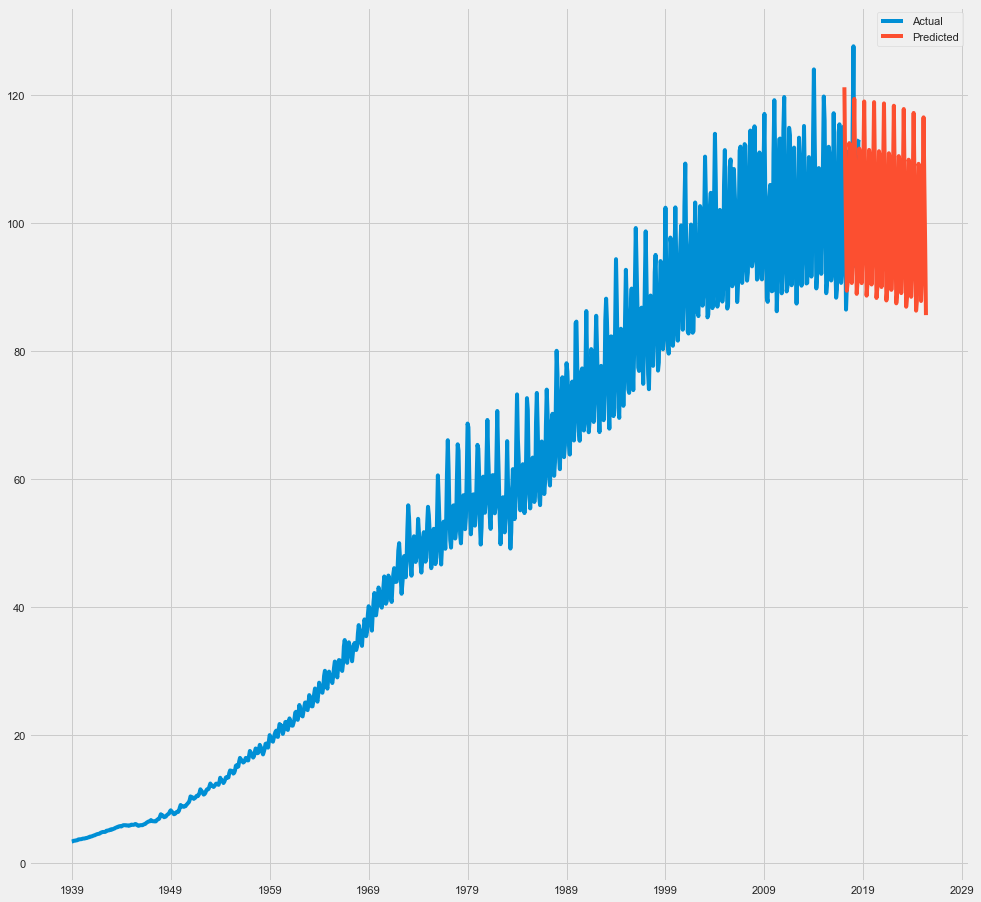

In [108]:
future_forecast = stepwise_model.predict(n_periods=100)
future_index = pd.date_range(start=test.index[0], periods=100, freq='M')

future_forecast_df = pd.DataFrame(future_forecast, index=future_index, columns=['Prediction'])

plt.figure(figsize=(15,15))
plt.plot(data.EnergyProd, label="Actual")
plt.plot(future_forecast_df.Prediction, label="Predicted")
plt.legend()

## Using Stats Models

From https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [100]:
sarimax = sm.tsa.statespace.sarimax.SARIMAX(train.EnergyProd, 
                                   order=(3, 1, 3),
                                   seasonal_order=(2,1,2, 12),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [69]:
fit_results = sarimax.fit()

fit_results.aic

1579.3925347495087

In [70]:
fit_results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.8861,0.309,-2.867,0.004,-1.492,-0.280
ar.L2,0.0690,0.153,0.451,0.652,-0.231,0.369
ar.L3,0.2019,0.169,1.196,0.232,-0.129,0.533
ma.L1,0.3862,0.314,1.230,0.219,-0.229,1.002
ma.L2,-0.9172,0.166,-5.536,0.000,-1.242,-0.592
ma.L3,-0.6455,0.277,-2.328,0.020,-1.189,-0.102
ar.S.L12,-0.0547,0.222,-0.246,0.805,-0.490,0.381
ar.S.L24,-0.2574,0.073,-3.537,0.000,-0.400,-0.115
ma.S.L12,-0.6459,0.235,-2.754,0.006,-1.106,-0.186
ma.S.L24,-2.766e-05,0.190,-0.000,1.000,-0.373,0.373


Really want $(P>|z|) \leq 0.05$

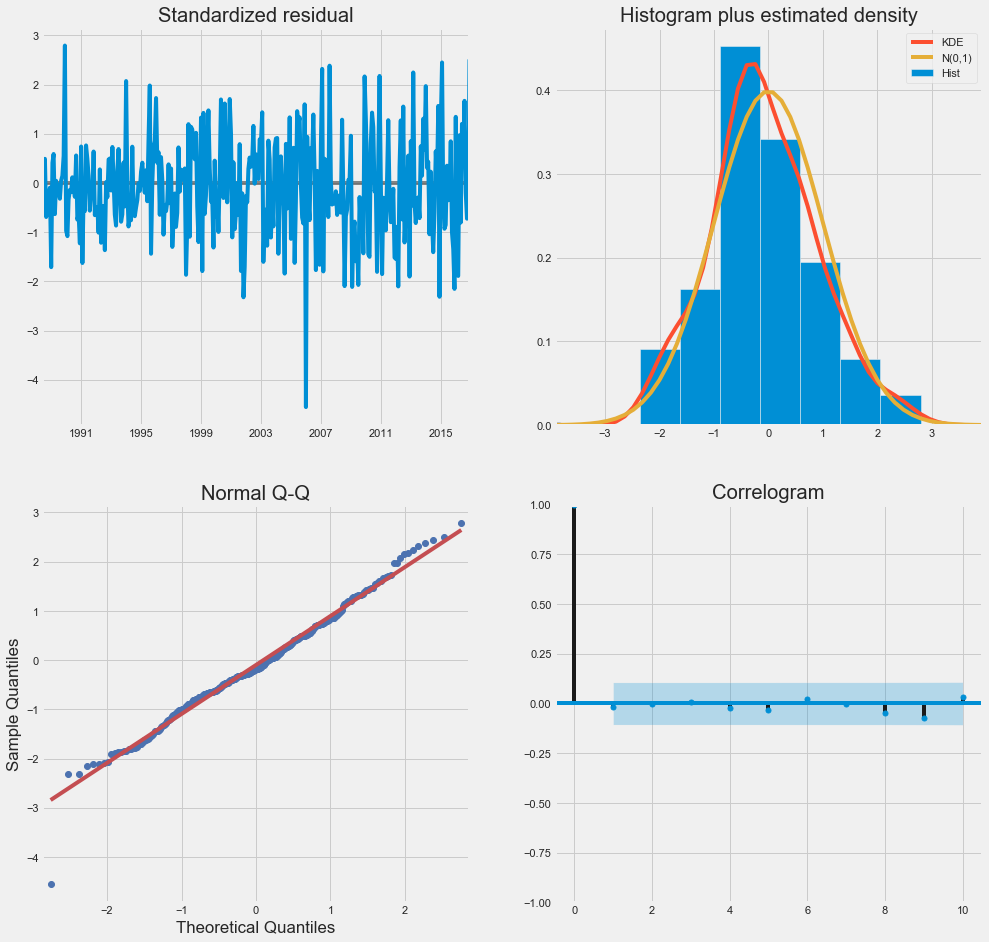

In [75]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(15, 15))
    fit_results.plot_diagnostics()

In [84]:
pred_dynamic = fit_results.get_prediction(start=test.index[0], end=test.index[-1], dynamic=True, full_results=False)
pred_dynamic_ci = pred_dynamic.conf_int()

In [86]:
pred_dynamic.predicted_mean

2017-01-01    121.674502
2017-02-01    109.897280
2017-03-01    100.387225
2017-04-01     90.574749
2017-05-01     91.862872
2017-06-01    103.412849
2017-07-01    112.673823
2017-08-01    112.505622
2017-09-01    101.232054
2017-10-01     92.254872
2017-11-01     96.223041
2017-12-01    111.883548
2018-01-01    120.950026
2018-02-01    112.046168
2018-03-01    102.776261
2018-04-01     90.845333
2018-05-01     92.502467
2018-06-01    103.577363
2018-07-01    112.666962
2018-08-01    111.849322
Freq: MS, dtype: float64

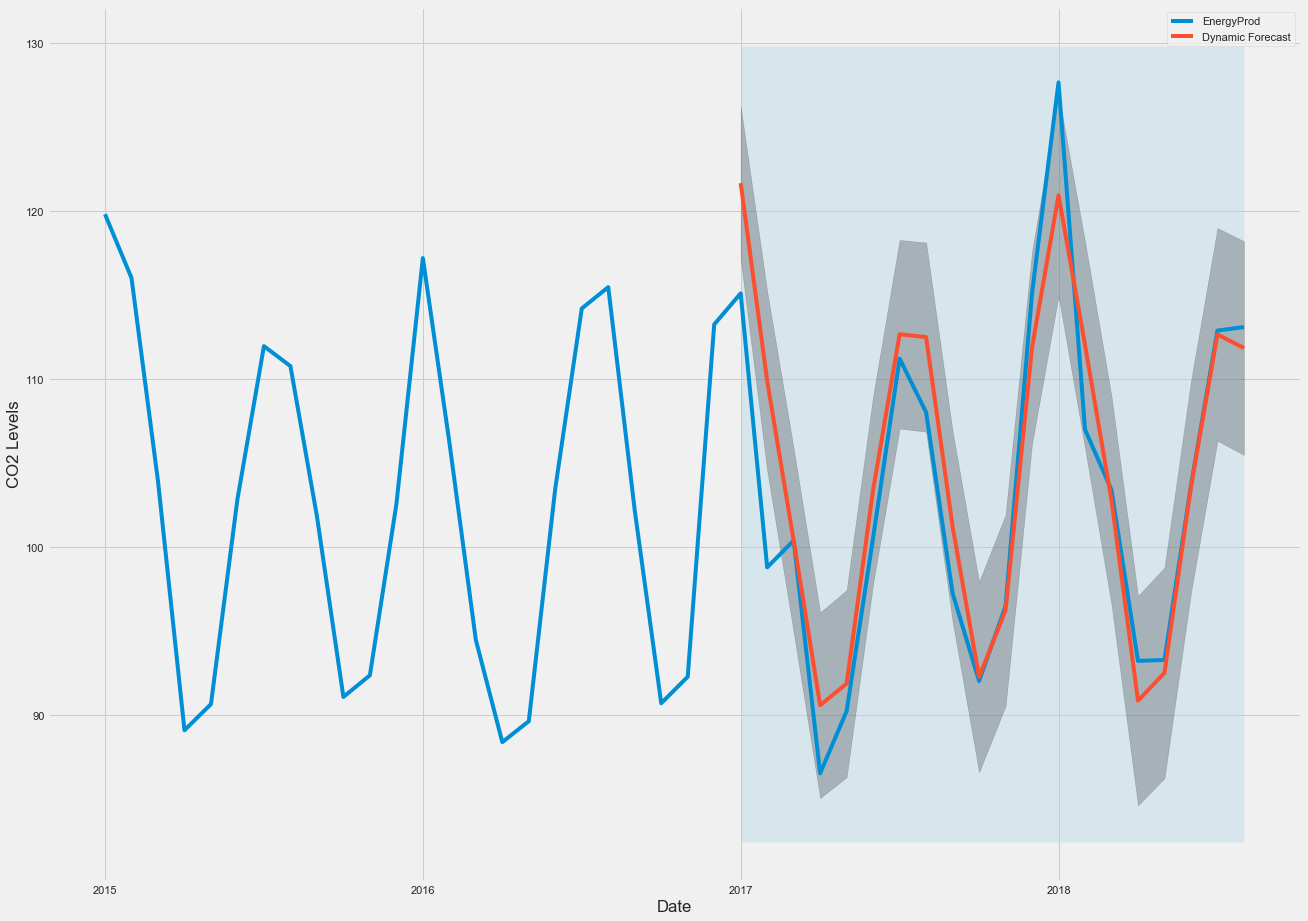

In [93]:
ax = data['2015':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), test.index[0], test.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

The alternate approach is to just add for $n$ time-steps into the future

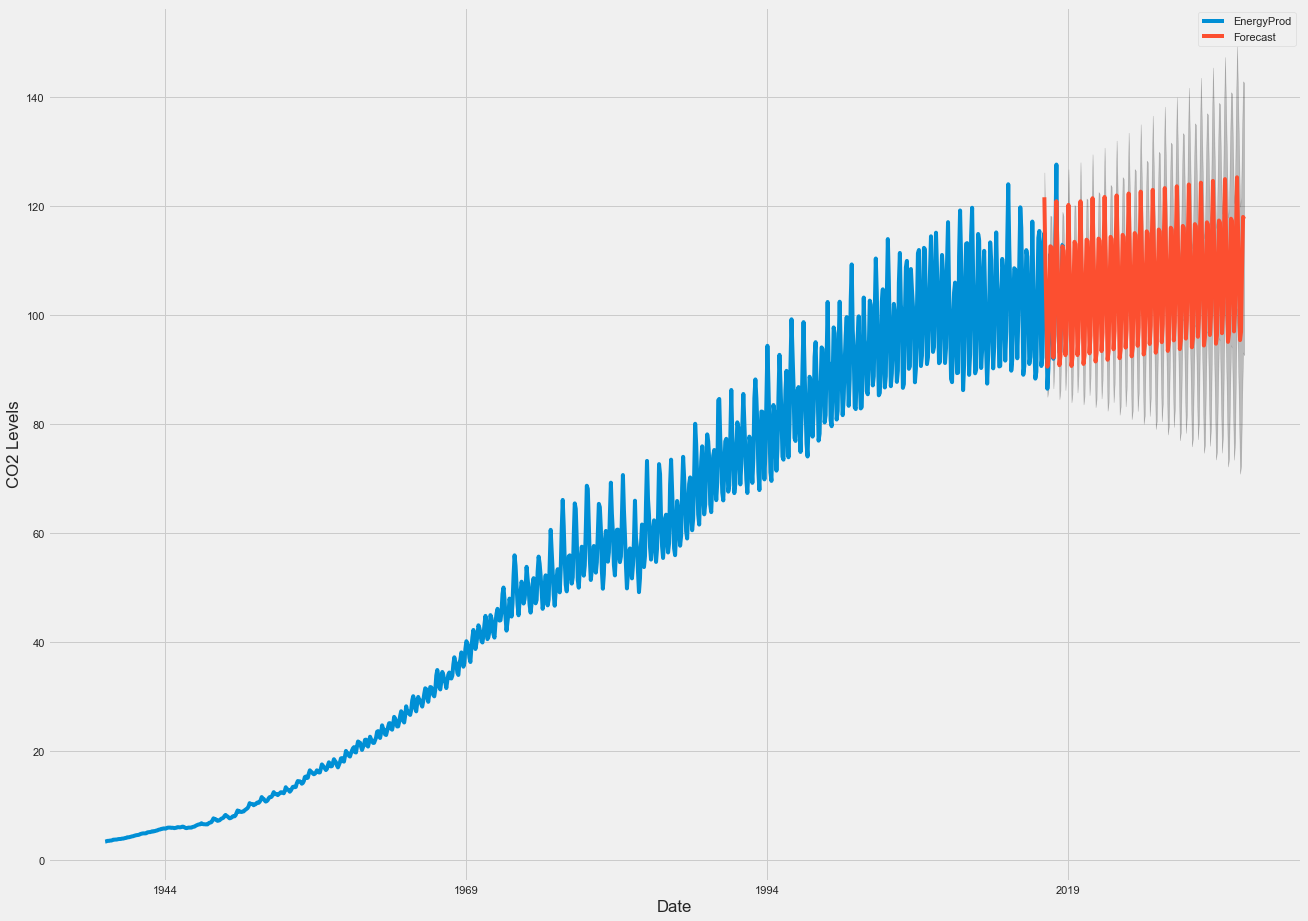

In [98]:
# Get forecast 500 steps ahead in future
pred_uc = fit_results.get_forecast(steps=200)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

# Plot it.
ax = data.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

This is additive, perhaps we should have used multiplicative

## Doing it Properly with ACF / PACF Plots

https://www.datascience.com/blog/introduction-to-forecasting-with-arima-in-r-learn-data-science-tutorials

In [147]:
import statsmodels.graphics.tsaplots as tsplt

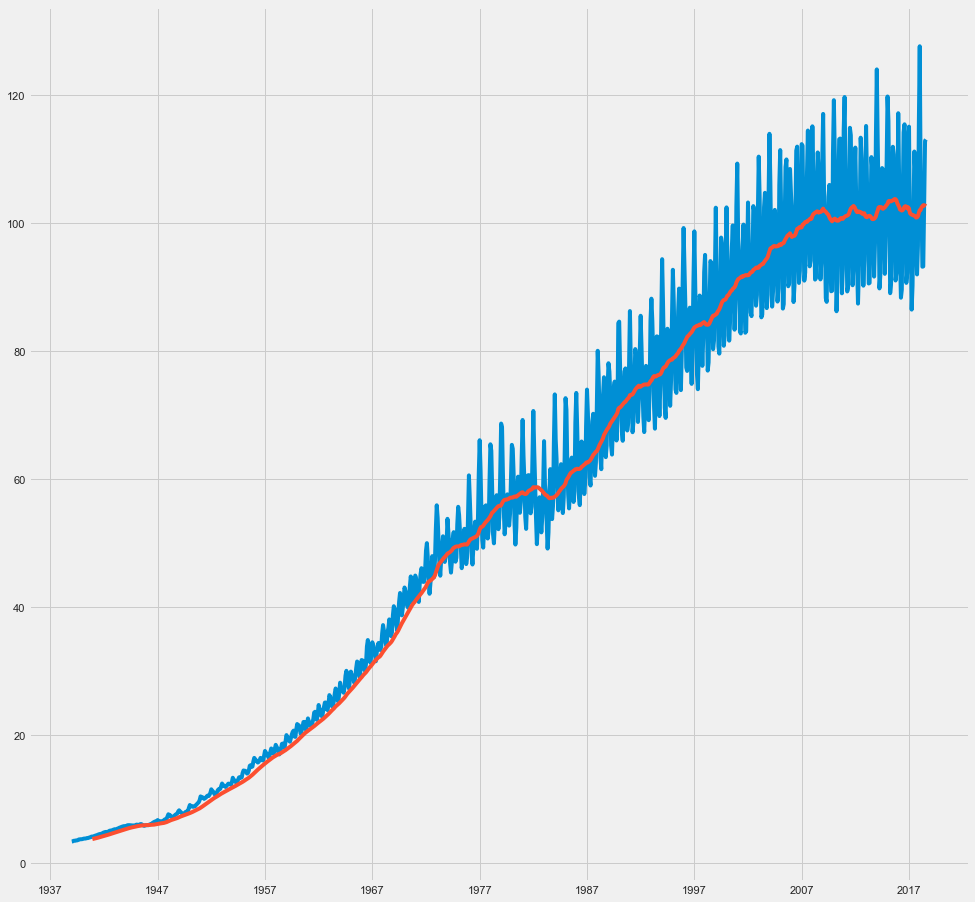

In [117]:
plt.figure(figsize=(15, 15))
plt.plot(data, label="Actual")
plt.plot(data.EnergyProd.rolling(window=24).mean(), label="Rolling Mean");

In [120]:
test_result = sm.tsa.stattools.adfuller(data.EnergyProd)

In [124]:
test_result

(-0.2609493370110557,
 0.9308558687138127,
 22,
 933,
 {'1%': -3.4373782772524315,
  '5%': -2.8646427696103305,
  '10%': -2.56842210151995},
 3840.5265077623153)

Since $0.93 > 0.05$ this isn't stationary

In [143]:
data['LnEnergyProd'] = np.log(data.EnergyProd)
_tmp = data.EnergyProd.diff(periods=12).diff(periods=1)
_lntmp = data.LnEnergyProd.diff(periods=12).diff(periods=1)

In [144]:
sm.tsa.stattools.adfuller(_tmp[13:-13])

(-9.894743816892861,
 3.481970223305636e-17,
 21,
 908,
 {'1%': -3.4375723382479735,
  '5%': -2.8647283387229963,
  '10%': -2.568467680189796},
 3748.100928868609)

Now it's stationary

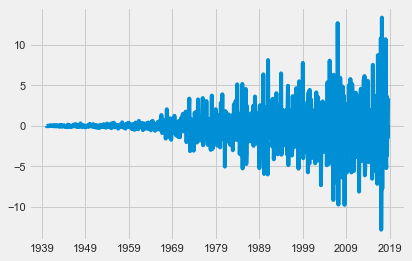

In [145]:
plt.plot(_tmp)

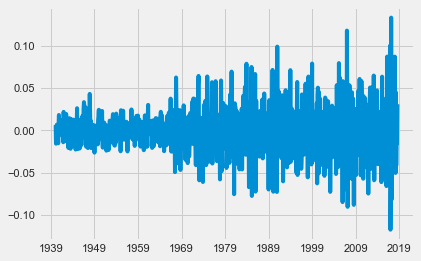

In [146]:
plt.plot(_lntmp)

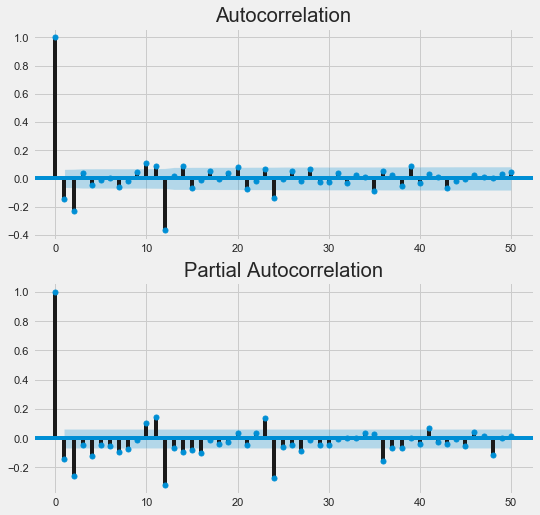

In [171]:
plt.figure(figsize=(8,8))
plt.subplot(211)
tsplt.plot_acf(data.LnEnergyProd.diff(12).diff(1).iloc[13:-13], ax=plt.gca(), lags=50)
plt.subplot(212)
tsplt.plot_pacf(data.LnEnergyProd.diff(12).diff(1).iloc[13:-13], ax=plt.gca(), lags=50)
plt.show()